In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    #%pip install bitsandbytes

    !git clone https://github.com/MartinKirkegaardDK/KDS_MI.git

    if not has_changed_dir:
        os.chdir('KDS_MI')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True

In [2]:
%load_ext autoreload
%autoreload 2

In [14]:
from drivers import (
    preprocessing,probe_confidence_intervals, 
    steering, create_steering_vectors, 
    steering_loss, 
    distance_plots, 
    create_average_activation_vectors, 
    visualising_steering_vectors,
    visualising_activations,
    visualize_probe_results
)

from pathlib import Path


## Data preprocessing

Preprocesses the multilingual data, by removing short sentences

In [ ]:
preprocessing.run()

## Analysis of residual stream activations

### PCA of activations

found device: cpu
Load data


  5%|▍         | 6/130 [00:16<05:39,  2.74s/it]


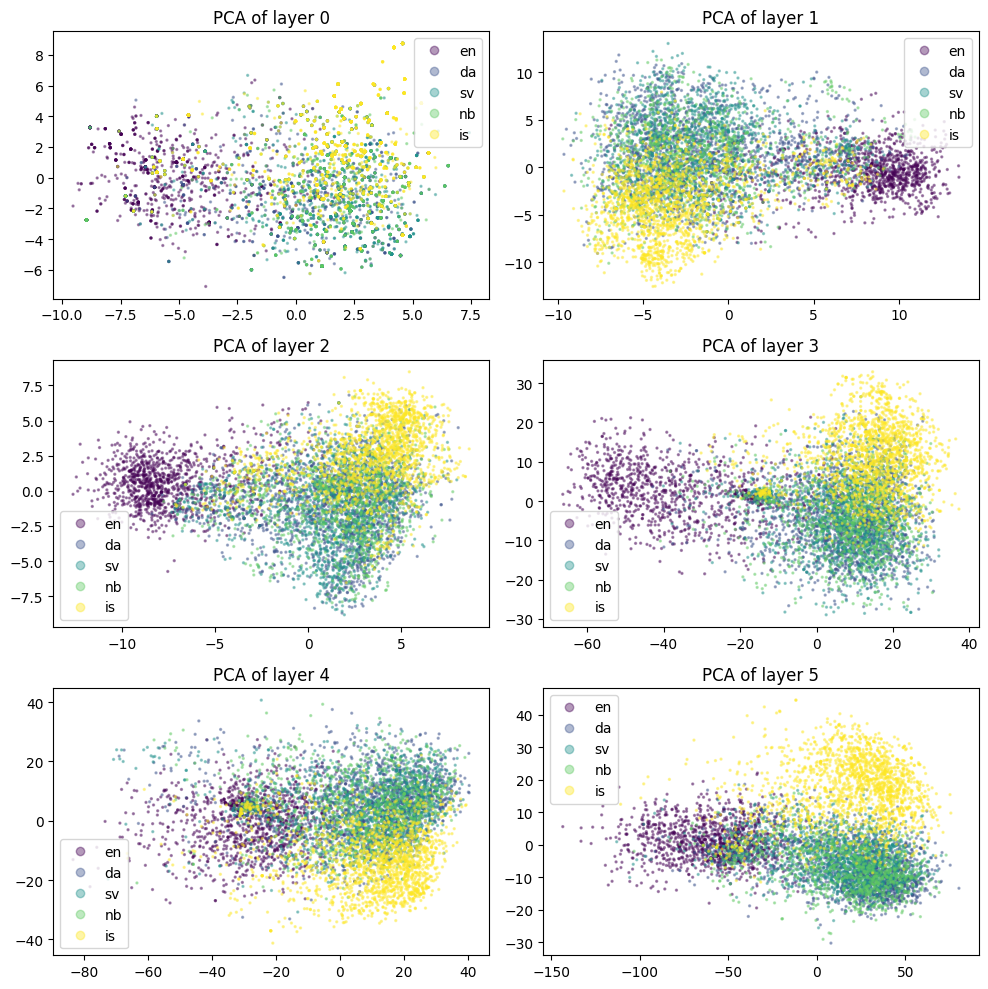

In [11]:
visualising_activations.run(model_name="EleutherAI/pythia-14m")

### Classification probes

In [ ]:
probe_confidence_intervals.run(
    model_name="AI-Sweden-Models/gpt-sw3-356m",
    reg_lambdas=[0.1, 0.5, 1, 2, 5, 10]
)

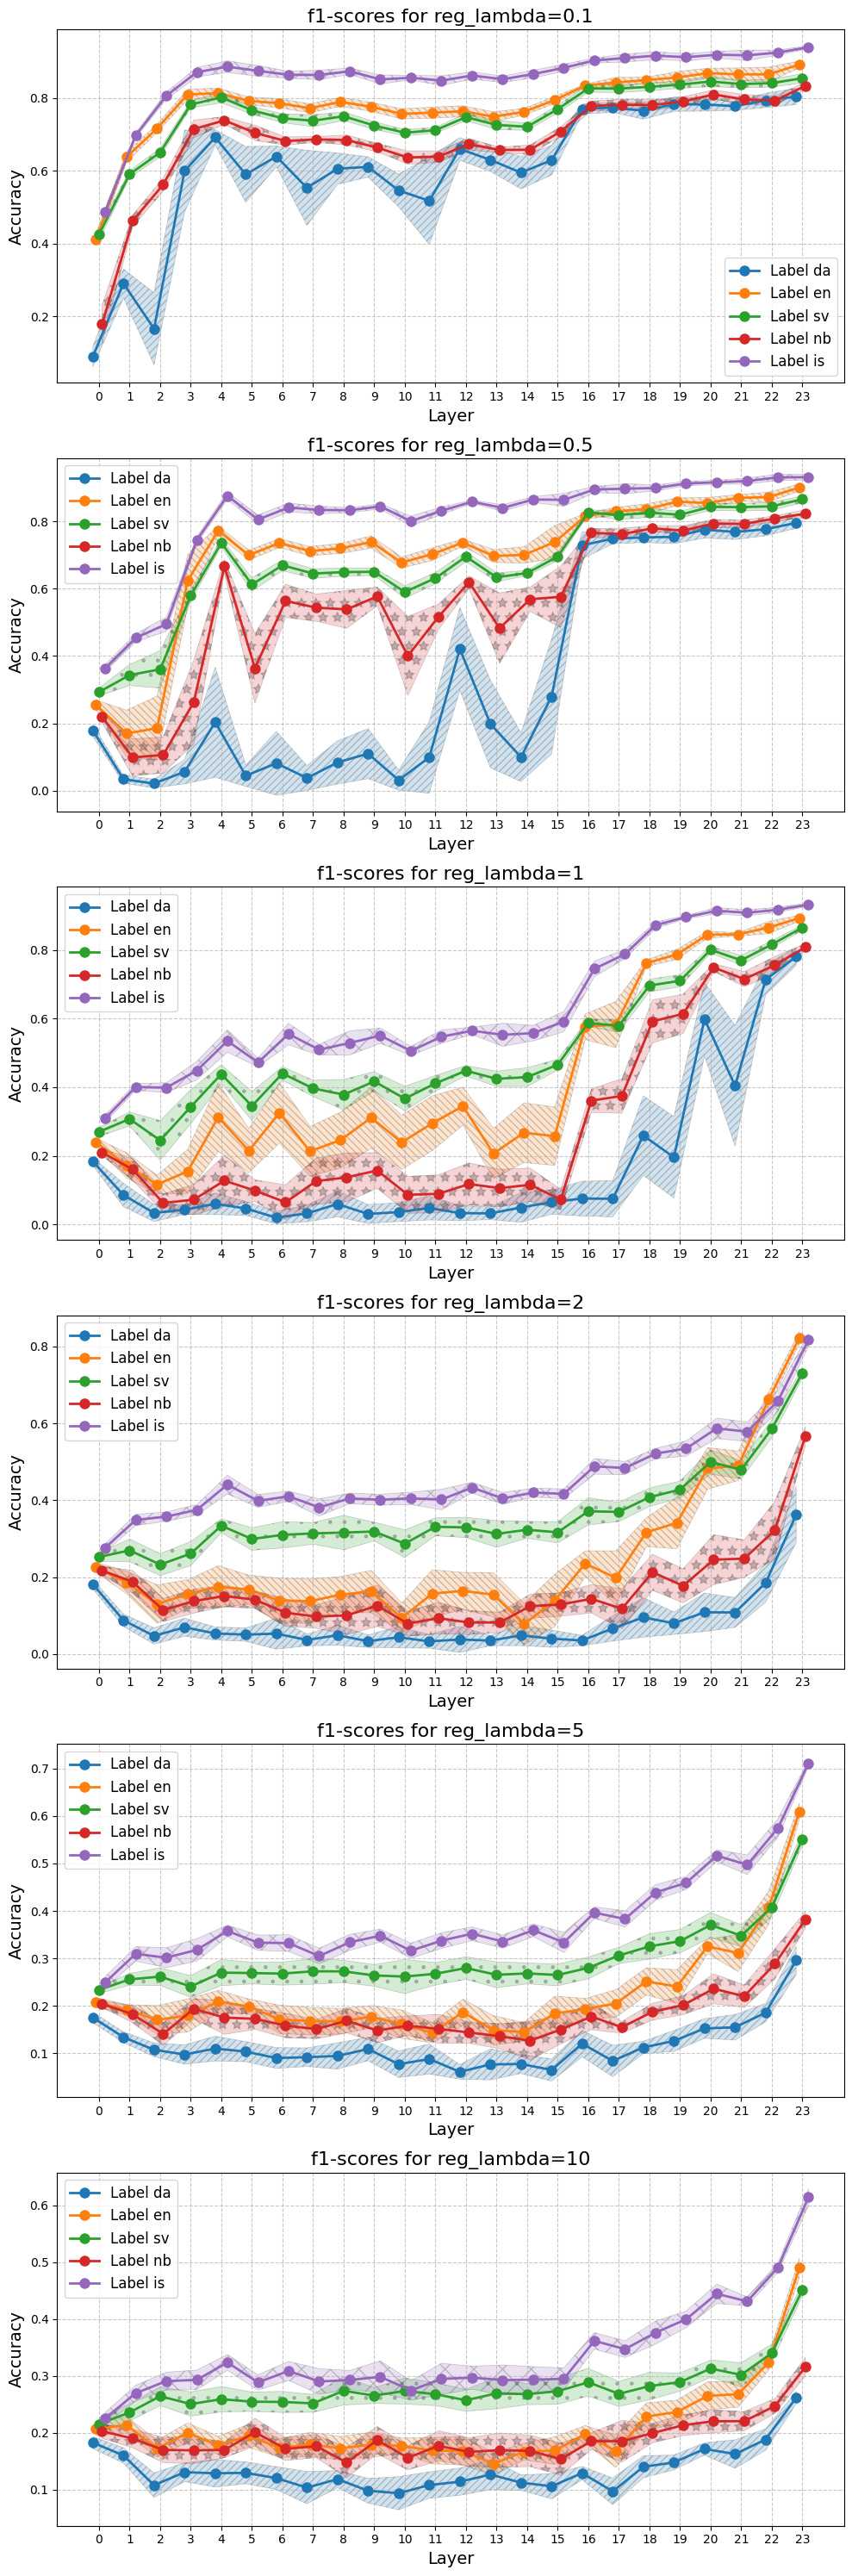

In [21]:
result_folder = Path('results/data/probe_confidence_intervals')

visualize_probe_results.run(
    probe_result_path_by_reg_lambda={
        0.1: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_0.1.json',
        0.5: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_0.5.json',
        1: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_1.json',
        2: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_2.json',
        5: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_5.json',
        10: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_10.json',
    }
)



## plots the distance plots

In [ ]:
#AI-Sweden-Models/gpt-sw3-356m
distance_plots.run("da","average_activation_vectors/gpt_sw3_356m/","euclidean")

## Create average activation vectors
these are the "base" steering vectors e.i. the average activations for different layers and languages.
This function generates them and the next block then splits them up for the analysis section

In [8]:
create_average_activation_vectors.run(["nb","is","da","en","sv"],"AI-Sweden-Models/gpt-sw3-356m","test_test")

found device: cpu
Load data


 20%|██        | 6/30 [00:41<02:44,  6.85s/it]


## Create steering vector
these are the steering vectors towards a specific language. This is different that

In [3]:
#AI-Sweden-Models/gpt-sw3-356m
create_steering_vectors.run(
    model_name="AI-Sweden-Models/gpt-sw3-356m",
    target_language="nb", 
    complement_languages=["is","da","en","sv"], 
    run_name="test_test"
)

Load model
found device: cpu
Load data


/Users/marki/Documents/GitHub/KDS_MI/utils/distance_plots.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  steering_vector = torch.load(str(path + file))


## Test steering vectors

In [ ]:
steering_vector_path = "steering_vectors/DA_PYTHIA/combined_steering_vector_layer_4_tensor.pt"
model_name = 'EleutherAI/pythia-14m'

steering.run(
    steering_vector_path=steering_vector_path,
    steering_lambda=5,
    affected_language="en",
    layer=4,
    model_name=model_name,
    data_folder='data/preprocessed/train'
)

## Measure steering vector loss impact

In [ ]:
steering_vector_folder = 'steering_vectors/DA_PYTHIA'

steering_loss.run(
    steering_vector_folder=steering_vector_folder,
    model_name='EleutherAI/pythia-14m',
    steering_lambda=5
)

## Plot steering vector PCAs

c:\Users\Bruger\Code\mechinterp\KDS_MI\drivers\visualising_steering_vectors.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  language: torch.load(steering_vector_paths_by

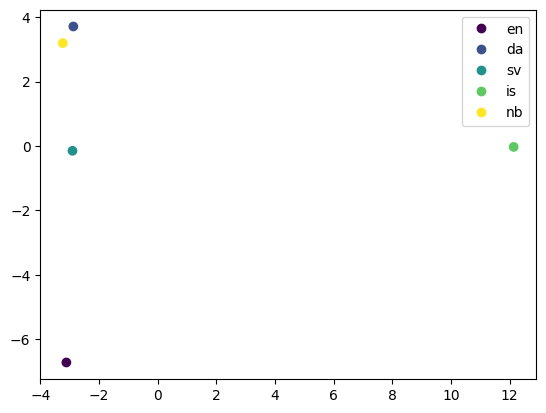

In [12]:
steering_vector_folder = Path('steering_vectors/')
layer = 16

visualising_steering_vectors.run(
    steering_vector_paths_by_language={
        'en': steering_vector_folder / f'EN/combined_steering_vector_layer_{layer}_tensor.pt',
        'da': steering_vector_folder / f'DA/combined_steering_vector_layer_{layer}_tensor.pt',
        'sv': steering_vector_folder / f'SV/combined_steering_vector_layer_{layer}_tensor.pt',
        'is': steering_vector_folder / f'IS/combined_steering_vector_layer_{layer}_tensor.pt',
        'nb': steering_vector_folder / f'NB/combined_steering_vector_layer_{layer}_tensor.pt'
    }
)

In [ ]:
visualising_activations.run(layer=20, model_name="AI-Sweden-Models/gpt-sw3-356m")